In [8]:
# Generate pulses with Gaussian noise
import numpy as np
from scipy.linalg import expm
import math
import pickle
import random
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import multiprocessing as mp

Ez = 3.933e10
dEz = 1.326e7
Ω = 410000.0
J = 1.59e6
# supp eqn.7
n = 1
T_pi_2 = math.sqrt(16 * n ** 2 - 1) / 4 / J

# stochastic noise deviation
std_uu = 16100*15
std_ud = 10100*15
std_du = 21000*15
std_dd = 0

# std_uu = 0
# std_ud = 0
# std_du = 0
# std_dd = 0

# open Cliff_indices1 put into data
with open("Cliff_indices_4.pkl", "rb") as f:
    data = pickle.load(f)
f.close()

with open("Prim_perfect.pkl", "rb") as f4:
    Prim_perfect = pickle.load(f4)
f4.close()


def fidelity(M_exp, M):
    return np.absolute(np.trace(np.dot(M_exp.conj().T, M))) / 4


# perfect gate
def H_RWA1_1d(w):
    return 1 / 2 * 2 * np.pi * w * np.array([[0, 0, 0, 0],
                                             [0, 0, 0, 1],
                                             [0, 0, 0, 0],
                                             [0, 1, 0, 0]])


def H_RWA1_1u(w):
    return 1 / 2 * 2 * np.pi * w * np.array([[0, 0, 1, 0],
                                             [0, 0, 0, 0],
                                             [1, 0, 0, 0],
                                             [0, 0, 0, 0]])


def H_RWA1_2d(w):
    return 1 / 2 * 2 * np.pi * w * np.array([[0, 0, 0, 0],
                                             [0, 0, 0, 0],
                                             [0, 0, 0, 1],
                                             [0, 0, 1, 0]])


def H_RWA1_2u(w):
    return 1 / 2 * 2 * np.pi * w * np.array([[0, 1, 0, 0],
                                             [1, 0, 0, 0],
                                             [0, 0, 0, 0],
                                             [0, 0, 0, 0]])


# cross error
def H_RWA2_1d(w, t):
    return 1 / 2 * 2 * np.pi * w * np.array([[0, 0, np.exp(-1j * J * 2 * np.pi * t), 0],
                                             [0, 0, 0, 0],
                                             [np.exp(1j * J * 2 * np.pi * t), 0, 0, 0],
                                             [0, 0, 0, 0]])


def H_RWA2_1u(w, t):
    return 1 / 2 * 2 * np.pi * w * np.array([[0, 0, 0, 0],
                                             [0, 0, 0, np.exp(1j * J * 2 * np.pi * t)],
                                             [0, 0, 0, 0],
                                             [0, np.exp(-1j * J * 2 * np.pi * t), 0, 0]])


def H_RWA2_2d(w, t):
    return 1 / 2 * 2 * np.pi * w * np.array([[0, np.exp(-1j * J * 2 * np.pi * t), 0, 0],
                                             [np.exp(1j * J * 2 * np.pi * t), 0, 0, 0],
                                             [0, 0, 0, 0],
                                             [0, 0, 0, 0]])


def H_RWA2_2u(w, t):
    return 1 / 2 * 2 * np.pi * w * np.array([[0, 0, 0, 0],
                                             [0, 0, 0, 0],
                                             [0, 0, 0, np.exp(1j * J * 2 * np.pi * t)],
                                             [0, 0, np.exp(-1j * J * 2 * np.pi * t), 0]])


def dH(std_uu, std_ud, std_du, std_dd):
    return np.array([[np.random.normal(0.0, std_uu), 0, 0, 0],
                     [0, np.random.normal(0.0, std_ud), 0, 0],
                     [0, 0, np.random.normal(0.0, std_du), 0],
                     [0, 0, 0, np.random.normal(0.0, std_dd)]])


# combine perfect and cross error
def H_RWA_1d(w, t, noise_std = [0, 0, 0, 0]):
    return H_RWA1_1d(w) + H_RWA2_1d(w, t) + dH(noise_std[0], noise_std[1], noise_std[2], noise_std[3])


def H_RWA_1u(w, t, noise_std = [0, 0, 0, 0]):
    return H_RWA1_1u(w) + H_RWA2_1u(w, t) + dH(noise_std[0], noise_std[1], noise_std[2], noise_std[3])


def H_RWA_2d(w, t, noise_std = [0, 0, 0, 0]):
    return H_RWA1_2d(w) + H_RWA2_2d(w, t) + dH(noise_std[0], noise_std[1], noise_std[2], noise_std[3])


def H_RWA_2u(w, t, noise_std = [0, 0, 0, 0]):
    return H_RWA1_2u(w) + H_RWA2_2u(w, t) + dH(noise_std[0], noise_std[1], noise_std[2], noise_std[3])

def get_gates(prim_key = 0, delta = 50, T_pi_2 = 0, noise_std = [0, 0, 0, 0]):
    L = np.linspace(0, T_pi_2, delta)
    A = np.identity(4)
    B = np.identity(4)
    if prim_key<8:
        dH_A = dH(noise_std[0], noise_std[1], noise_std[2], noise_std[3])
        if prim_key==0:
            dH_B = dH(noise_std[0], noise_std[1], noise_std[2], noise_std[3])
            for t in L:
                H_RWA_2u = H_RWA1_2u(Ω)  + dH_A
                H_RWA_2d = H_RWA1_2d(Ω)  + dH_B
#                 H_RWA_2u = H_RWA1_2u(Ω) + H_RWA2_2u(Ω, t) + dH_A
#                 H_RWA_2d = H_RWA1_2d(Ω) + H_RWA2_2d(Ω, t) + dH_B
                A = np.dot(expm(-1j * H_RWA_2u * L[1]), A)
                B = np.dot(expm(-1j * H_RWA_2d * L[1]), B)
        elif prim_key==1:
            dH_B = dH(noise_std[0], noise_std[1], noise_std[2], noise_std[3])
            for t in L:
                H_RWA_1u = H_RWA1_1u(Ω) + dH_A
                H_RWA_1d = H_RWA1_1d(Ω) + dH_B
#                 H_RWA_1u = H_RWA1_1u(Ω) + H_RWA2_1u(Ω, t) + dH_A
#                 H_RWA_1d = H_RWA1_1d(Ω) + H_RWA2_1d(Ω, t) + dH_B
                A = np.dot(expm(-1j * H_RWA_1u * L[1]), A)
                B = np.dot(expm(-1j * H_RWA_1d * L[1]), B)
        elif prim_key==2:
            dH_B = dH(noise_std[0], noise_std[1], noise_std[2], noise_std[3])
            for t in L:
                H_RWA_2u = H_RWA1_2u(Ω) + dH_A
                H_RWA_2d = H_RWA1_2d(Ω) + dH_B
#                 H_RWA_2u = H_RWA1_2u(Ω) + H_RWA2_2u(Ω, t) + dH_A
#                 H_RWA_2d = H_RWA1_2d(Ω) + H_RWA2_2d(Ω, t) + dH_B
                A = np.dot(expm(-1j * H_RWA_2u * L[1]), A)
                B = np.dot(expm(1j * H_RWA_2d * L[1]), B)
        elif prim_key==3:
            dH_B = dH(noise_std[0], noise_std[1], noise_std[2], noise_std[3])
            for t in L:
                H_RWA_1u = H_RWA1_1u(Ω) + dH_A
                H_RWA_1d = H_RWA1_1d(Ω) + dH_B
#                 H_RWA_1u = H_RWA1_1u(Ω) + H_RWA2_1u(Ω, t) + dH_A
#                 H_RWA_1d = H_RWA1_1d(Ω) + H_RWA2_1d(Ω, t) + dH_B
                A = np.dot(expm(-1j * H_RWA_1u * L[1]), A)
                B = np.dot(expm(1j * H_RWA_1d * L[1]), B)
        elif prim_key==4:
            for t in L:
                H_RWA_2u = H_RWA1_2u(Ω) + dH_A
#                 H_RWA_2u = H_RWA1_2u(Ω) + H_RWA2_2u(Ω, t) + dH_A
                A = np.dot(expm(-1j * H_RWA_2u * L[1]), A)
                B = np.dot(expm(-1j * H_RWA_2u * L[1]), B)
        elif prim_key==5:
            for t in L:
                H_RWA_1u = H_RWA1_1u(Ω) + dH_A
#                 H_RWA_1u = H_RWA1_1u(Ω) + H_RWA2_1u(Ω, t) + dH_A
                A = np.dot(expm(-1j * H_RWA_1u * L[1]), A)
                B = np.dot(expm(-1j * H_RWA_1u * L[1]), B)
        elif prim_key==6:
            for t in L:
                H_RWA_2d = H_RWA1_2d(Ω) + dH_A
#                 H_RWA_2d = H_RWA1_2d(Ω) + H_RWA2_2d(Ω, t) + dH_A
                A = np.dot(expm(1j * H_RWA_2d * L[1]), A)
                B = np.dot(expm(1j * H_RWA_2d * L[1]), B)
        elif prim_key==7:
            for t in L:
                H_RWA_1d = H_RWA1_1d(Ω) + dH_A
#                 H_RWA_1d = H_RWA1_1d(Ω) + H_RWA2_1d(Ω, t) + dH_A
                A = np.dot(expm(1j * H_RWA_1d * L[1]), A)
                B = np.dot(expm(1j * H_RWA_1d * L[1]), B)
        return np.dot(A, B)
    else:
        return Prim_perfect[prim_key]

# for i in range(14):
#     print(fidelity(Prim_perfect[i], get_gates(prim_key=i, T_pi_2=T_pi_2, noise_std=[std_uu, std_ud, std_du, std_dd])))

def error_initial_state(e1, e2, e3):
    return np.array([[(1-e1-e2-e3), 0, 0, 0],
                     [0, e1, 0, 0],
                     [0, 0, e2, 0],
                     [0, 0, 0, e3]])

def Is_Inverse(A, B):
    if np.allclose(np.absolute(np.trace(np.dot(A, B))), 4):
        return True
    else:
        return False

def fidelity(M_exp, M):
    return np.absolute(np.trace(np.dot(M_exp.conj().T, M))) / 4

def get_s(g1):
    p = np.identity(4)  # 計數器for p@p1@p2....
    for i in range(len(g1)):
        array = g1[i]
        for j in range(len(array)):
            a = get_gates(prim_key=array[j], T_pi_2=T_pi_2, noise_std=[std_uu, std_ud, std_du, std_dd])
            p = p @ a
    return p

def get_s_perfect(g1):
    p = np.identity(4)  # 計數器for p@p1@p2....
    for i in range(len(g1)):
        array = g1[i]
        for j in range(len(array)):
            p = p @ Prim_perfect[array[j]]
    return p

def get_perfect_unitary(seq):  # Get perfect gate from decomposition info. in "Cliff_indices_4.pkl"
    p = np.identity(4)
    for j in range(len(seq)):
        p = p @ Prim_perfect[seq[j]]
    return p

def get_nonperfect_unitary(seq):  # Get perfect gate from decomposition info. in "Cliff_indices_4.pkl"
    p = np.identity(4)
    for i in range(len(seq)):
        p = p @ get_gates(prim_key=seq[i], T_pi_2=T_pi_2, noise_std=[std_uu, std_ud, std_du, std_dd])
    return p

# given list , return c^-1
def c_m(c1):
    a = get_s_perfect(c1)
    for k in range(len(data)):
        b = get_perfect_unitary(data[k])
        if Is_Inverse(a, b):
            return get_nonperfect_unitary(data[k])

def RB_single_seq(L, repetition=125, ini_error=[0, 0, 0], rd_error=[0, 0, 0]):
    s_re = repetition  # repeated times for each sequence
    initial = error_initial_state(ini_error[0], ini_error[1], ini_error[2])
    num_uu = 0
    list = random.choices(data, k=L)  # data 隨便可重複取m個
    for j in range(repetition):
        seq_k = c_m(list) @ get_s(list)  # k_th
#############################################Readout##########################################################################
        final_state = seq_k @ initial @ seq_k.conj().T
        proj_measure = error_initial_state(rd_error[0], rd_error[1], rd_error[2])
        final_prob = np.trace(proj_measure @ final_state)
        uu_count = [1, 0]
        a = random.choices(uu_count, weights=[final_prob, 1-final_prob], k=1)
        num_uu = num_uu + a[0]
    return num_uu / repetition
#############################################Readout##########################################################################

L =  1  is done.
L =  2  is done.
L =  3  is done.
L =  4  is done.
L =  5  is done.
L =  6  is done.
L =  7  is done.
L =  8  is done.
L =  9  is done.
L =  10  is done.
L =  11  is done.
L =  12  is done.
L =  13  is done.
L =  14  is done.
L =  15  is done.
L =  16  is done.
L =  17  is done.
L =  18  is done.
L =  19  is done.
L =  20  is done.
L =  22  is done.
L =  24  is done.
L =  26  is done.
L =  28  is done.
L =  30  is done.
L =  32  is done.
L =  34  is done.
L =  36  is done.
L =  38  is done.
L =  40  is done.
L =  45  is done.
L =  50  is done.
L =  55  is done.
L =  60  is done.
F_Ciff = 1 - r =  0.9402898299565288
A =  0.7244589442621061
B =  0.2500783807223942


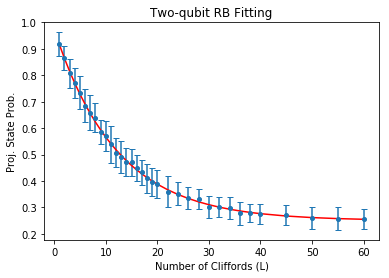

In [9]:
#define the gate length series chosen to run RB protocol
l1 = np.arange(1, 20, 1)
l2 = np.arange(20, 40, 2)
l3 = np.arange(40, 65, 5)
x = np.hstack((l1, l2, l3))

y = []
yerr = []

# N = 2  # samples for each data point (算標準差即是使用每個data point對應的N個數據)
K = 51  # choices of S sequence 相同長度 重複取k次不同seq(等同K_L參數)
s_re = 125  # repeated times for each sequence
initial_error = [0, 0, 0]   #[e_ud, e_du, e_dd]
readout_error = [0, 0, 0]

def RB_loop(L):
    return RB_single_seq(L, repetition=s_re, ini_error=initial_error, rd_error=readout_error)


if __name__ == '__main__':
    for m in x:
        a = [m]*K
        pool = mp.Pool()
        res = pool.map(RB_loop, a)  # RB rep)
        y.append(np.mean(res))
        yerr.append(np.std(res))
        print("L = ", m, " is done.")
        pool.close()
        pool.join()

    # saving the results
    f5 = open('2q_RB_simu_L.pkl', 'wb')
    pickle.dump(x, f5)
    f5.close()

    f6 = open('2q_RB_simu_y.pkl', 'wb')
    pickle.dump(y, f6)
    f6.close()

    f7 = open('2q_RB_simu_yerr.pkl', 'wb')
    pickle.dump(yerr, f7)
    f7.close()

    # Fitting function
    def func(x, A, B, r):
        return A * (1 - 4 / 3 * r) ** x + B

    # def func(x, A):
    #     return  * (1 - 4/3*0.053)**x + 0.25

    popt, pcov = curve_fit(func, x, y, p0=[1, 0, 0], bounds=(0, 1), maxfev=5000)
    # p0 is the guess of the parameters. Guess B ~ 0 (ideally be 0.25) and r ~ 0 (no noise model now so r should be ultra low)
    print("F_Ciff = 1 - r = ", 1 - popt[2])
    print("A = ", popt[0])
    print("B = ", popt[1])

    plt.errorbar(x, y, yerr=yerr, fmt='o', markersize=4, capsize=3)
    plt.plot(x, func(x, *popt), 'r-')
    # plt.plot(x, func(x, 0.75, 0.25, 0.053), 'b-')
    plt.ylim(top=1.0)
    plt.xlabel("Number of Cliffords (L)")
    plt.ylabel("Proj. State Prob.")
    plt.title("Two-qubit RB Fitting")
    plt.show()